In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from numpy import unique, where
import matplotlib.pyplot as plt

import os
os.chdir('../../')

from modules import preproc
from modules.join_data import join_y
from modules import feature_eng
from modules import cluster_intelligence
from modules.evaluate_model import get_eval_scores
from modules.dbscan_grid_search import run_dbscan_gs, get_best_models
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows',150)
pd.set_option('display.max_columns',1000)

## Reading in data and preproc

In [2]:
# laptops
laptops = pd.read_json('full_data/laptops.json')
laptops = join_y(laptops, 'raw_data/laptops_sales.csv')
laptops = preproc.clean_cols(laptops)
laptops = preproc.fill_empty_lists(laptops)
laptops = preproc.preprocess_reviews(laptops)
laptops = feature_eng.generate_features(laptops)
#laptops = feature_eng.do_PCA(laptops)
laptops['TOTAL_SALES_QBINNED'] = pd.qcut(laptops['TOTAL_SALES'], 3, labels=[0,1,2])

# phones
phones = pd.read_json('full_data/smartphones.json')
phones = join_y(phones, 'raw_data/phone_sales.csv')
phones = preproc.clean_cols(phones)
phones = preproc.fill_empty_lists(phones)
phones = preproc.preprocess_reviews(phones)
phones = feature_eng.generate_features(phones)
#phones = feature_eng.do_PCA(phones)
phones['TOTAL_SALES_QBINNED'] = pd.qcut(phones['TOTAL_SALES'], 3, labels=[0,1,2])
# desktops
desktops = pd.read_json('full_data/desktops.json')
desktops = join_y(desktops, 'raw_data/desktops_sales.csv')
desktops = preproc.clean_cols(desktops)
desktops = preproc.fill_empty_lists(desktops)
desktops = preproc.preprocess_reviews(desktops)
desktops = feature_eng.generate_features(desktops)
#desktops = feature_eng.do_PCA(desktops)
desktops['TOTAL_SALES_QBINNED'] = pd.qcut(desktops['TOTAL_SALES'], 3, labels=[0,1,2])
# tablets
tablets = pd.read_json('full_data/tablets.json')
tablets = join_y(tablets, 'raw_data/tablet_sales.csv')
tablets = tablets[tablets['no_reviews'].notna()]
tablets = preproc.clean_cols(tablets)
tablets = preproc.fill_empty_lists(tablets)
tablets = preproc.preprocess_reviews(tablets)
tablets = feature_eng.generate_features(tablets)
#tablets = feature_eng.do_PCA(tablets)
tablets['TOTAL_SALES_QBINNED'] = pd.qcut(tablets['TOTAL_SALES'], 3, labels=[0,1,2])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]    

## Scaling

In [3]:
laptops = laptops.select_dtypes(include=['float', 'int64','int32','float64'])
laptops['price/Rvol'] = laptops['price/Rvol'].replace(np.inf, laptops['price/Rvol'].median())
for col in laptops.columns:
    laptops[col] = laptops[col].replace(np.nan, laptops[col].median())
laptops = (laptops-laptops.mean())/laptops.std()

laptops = feature_eng.get_y_true(laptops)



In [4]:
phones = phones.select_dtypes(include=['float', 'int64','int32','float64'])
phones['price/Rvol'] = phones['price/Rvol'].replace(np.inf, phones['price/Rvol'].median())
for col in phones.columns:
    phones[col] = phones[col].replace(np.nan, phones[col].median())
phones = (phones-phones.mean())/phones.std()

phones = feature_eng.get_y_true(phones)


In [5]:
tablets = tablets.select_dtypes(include=['float', 'int64','int32','float64'])
tablets['price/Rvol'] = tablets['price/Rvol'].replace(np.inf, tablets['price/Rvol'].median())
for col in tablets.columns:
    tablets[col] = tablets[col].replace(np.nan, tablets[col].median())
tablets = (tablets-tablets.mean())/tablets.std()

tablets = feature_eng.get_y_true(tablets)


In [7]:
desktops = desktops.select_dtypes(include=['float', 'int64','int32','float64'])
desktops['price/Rvol'] = desktops['price/Rvol'].replace(np.inf, desktops['price/Rvol'].median())
for col in desktops.columns:
    desktops[col] = desktops[col].replace(np.nan, desktops[col].median())
desktops = (desktops-desktops.mean())/desktops.std()

desktops = feature_eng.get_y_true(desktops)


In [8]:
laptops.name = 'laptops'
desktops.name = 'desktops'
phones.name = 'phones'
tablets.name = 'tablets'

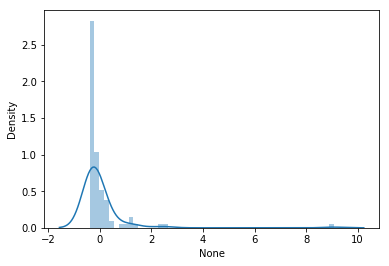

In [40]:
sns.distplot(laptops[['no_reviews']])

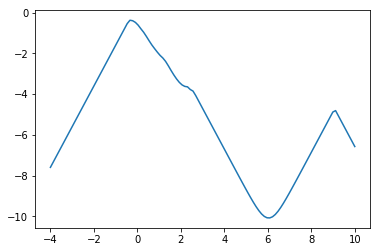

In [83]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='exponential', bandwidth=0.5).fit(laptops[['no_reviews']])
s = np.linspace(-4,10,112)
e = kde.score_samples(s.reshape(-1,1))
plt.plot(s,e)



In [89]:
#Local minima at s=6
# points over s=6 will be the high sales cluster
laptops['kde_loc'] = pd.Series(s, index=laptops.index)
laptops.loc[(laptops['kde_loc'] >=9), 'y_pred'] = -1
laptops.loc[(laptops['kde_loc'] <9), 'y_pred'] = 0

In [90]:
len(laptops.loc[laptops['y_pred']==-1])

8

In [91]:
laptops.loc[laptops['y_pred']==-1]

,price,remotekey,shelf_order,no_reviews,recommendation_percent,summary_star_rating,TOTAL_SALES,neg_reviews,pos_reviews,price/Rvol,Rvol/%rec,posR/Rvol,negR/Rvol,y_true,kde_loc,y_pred
124,2.431434,-0.400637,0.428934,-0.295997,0.601606,0.557484,-0.458715,-0.427543,-0.287388,0.836307,-0.356526,0.521030,-0.420446,0.0,9.117117,-1.0
125,1.334983,-0.400697,0.485386,0.417878,0.601606,0.609473,0.558767,-0.427543,0.462008,-0.444182,0.334909,0.521030,-0.420446,0.0,9.243243,-1.0
126,1.334983,-0.529336,0.541838,-0.069646,0.323177,0.453507,-0.217355,0.149382,-0.086331,-0.252575,-0.097688,-0.856664,0.476882,0.0,9.369369,-1.0
127,-0.614528,-0.583600,0.598290,-0.313408,0.601606,0.557484,-0.332652,-0.427543,-0.305666,-0.188457,-0.373390,0.521030,-0.420446,0.0,9.495495,-1.0
128,-0.746103,-0.584192,0.654742,1.201398,0.171306,0.297541,1.278362,4.187858,1.010346,-0.556304,1.411580,-1.612898,1.062096,-1.0,9.621622,-1.0
129,-0.943464,0.306336,1.501521,-0.069646,0.601606,0.557484,0.367204,-0.427543,-0.068053,-0.509828,-0.137291,-0.167817,-0.420446,0.0,9.747748,-1.0
130,0.677113,-0.527698,1.557973,0.783521,0.576295,0.609473,0.797884,-0.427543,0.827567,-0.505089,0.700642,0.328558,-0.420446,0.0,9.873874,-1.0
131,0.677113,-0.527710,1.614425,0.000000,0.601606,0.609473,0.060793,-0.427543,0.023337,-0.369870,-0.069834,0.521030,-0.420446,0.0,10.000000,-1.0


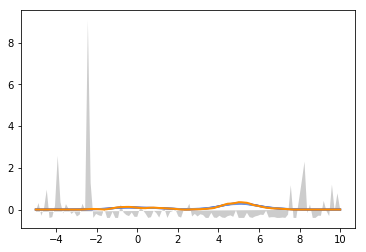

In [39]:


X_plot = np.linspace(-5, 10, 112)[:, np.newaxis]

true_dens = laptops[['no_reviews']]

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')
colors = ['navy', 'cornflowerblue', 'darkorange']
kernels = ['gaussian', 'exponential', 'epanechnikov']
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), color=color, lw=lw,
            linestyle='-', label="kernel = '{0}'".format(kernel))


In [36]:
len(X)

100

## 'no_reviews','Rvol/%rec','pos_reviews'

In [8]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews','Rvol/%rec','pos_reviews'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,combined_score
0,1.000000,0.280871,1.65,7,0.640436
0,1.000000,0.280871,1.75,7,0.640436
0,1.000000,0.280871,1.70,7,0.640436
0,0.599567,0.680619,1.20,5,0.640093
0,0.587907,0.680619,1.05,7,0.634263
0,0.586310,0.680619,1.10,5,0.633464
0,0.586310,0.680619,1.15,4,0.633464
0,0.586310,0.680619,1.10,2,0.633464
0,0.586310,0.680619,1.20,4,0.633464
0,0.586310,0.680619,1.15,2,0.633464


## no_reviews , Rvol/%rec

In [9]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews','Rvol/%rec'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,combined_score
0,1.000000,0.294760,1.35,6,0.647380
0,1.000000,0.294760,1.40,7,0.647380
0,1.000000,0.294760,1.25,7,0.647380
0,1.000000,0.294760,1.30,7,0.647380
0,1.000000,0.294760,1.45,7,0.647380
0,1.000000,0.294760,1.45,6,0.647380
0,1.000000,0.294760,1.35,7,0.647380
0,1.000000,0.294760,1.50,6,0.647380
0,1.000000,0.294760,1.40,6,0.647380
0,0.599567,0.680619,0.95,5,0.640093


In [10]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,combined_score
0,0.711310,0.630619,0.60,7,0.670964
0,0.711310,0.630619,0.60,6,0.670964
0,0.815476,0.516982,0.65,6,0.666229
0,0.624567,0.680619,0.65,5,0.652593
0,0.815476,0.485732,0.70,6,0.650604
0,1.000000,0.294760,0.90,7,0.647380
0,0.611310,0.680619,0.60,5,0.645964
0,0.611310,0.680619,0.65,4,0.645964
0,0.611310,0.680619,0.60,4,0.645964
0,1.000000,0.280871,1.00,7,0.640436


In [8]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['Rvol/%rec'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,combined_score
0,1.000000,0.294760,1.05,6,0.647380
0,0.701389,0.581187,0.80,3,0.641288
0,0.593202,0.680619,0.75,4,0.636910
0,0.593202,0.680619,0.75,3,0.636910
0,0.593202,0.680619,0.75,2,0.636910
0,0.591346,0.680619,0.65,7,0.635982
0,0.583333,0.680619,0.70,2,0.631976
0,0.583333,0.680619,0.70,3,0.631976
0,0.583333,0.680619,0.70,4,0.631976
0,0.579344,0.680619,0.65,3,0.629981


In [11]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews','Rvol/%rec','pos_reviews','neg_reviews'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,combined_score
0,0.591346,0.680619,1.70,2,0.635982
0,0.517912,0.753346,1.25,2,0.635629
0,0.587907,0.680619,1.65,2,0.634263
0,0.580616,0.680619,1.60,2,0.630617
0,0.579344,0.680619,1.50,3,0.629981
0,0.579344,0.680619,1.55,2,0.629981
0,0.579344,0.680619,1.35,3,0.629981
0,0.579344,0.680619,1.45,3,0.629981
0,0.579344,0.680619,1.40,3,0.629981
0,0.579344,0.680619,1.50,2,0.629981


In [12]:
# This is PCA over 12 odd features (from module)
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['c1','c2'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,combined_score
0,0.134595,0.866667,0.25,5,0.500631
0,0.530492,0.413131,1.05,5,0.471812
0,0.536523,0.399242,1.05,6,0.467883
0,0.497024,0.435859,1.20,3,0.466441
0,0.281080,0.644003,1.05,3,0.462541
0,0.429924,0.463636,1.15,3,0.446780
0,0.390837,0.500253,1.05,4,0.445545
0,0.534361,0.354104,1.05,7,0.444233
0,0.750000,0.104482,1.95,7,0.427241
0,0.750000,0.104482,1.90,7,0.427241


In [13]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews','Rvol/%rec','price'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,combined_score
0,0.424862,0.730619,1.05,4,0.577740
0,0.421202,0.730619,1.00,5,0.575910
0,0.419001,0.730619,1.00,4,0.574810
0,0.419001,0.730619,0.95,5,0.574810
0,0.417663,0.730619,1.25,2,0.574141
0,0.405733,0.730619,0.90,7,0.568176
0,0.404160,0.730619,0.95,4,0.567389
0,0.916667,0.213510,1.95,6,0.565088
0,0.399071,0.730619,1.10,3,0.564845
0,0.446789,0.680619,1.10,5,0.563704


In [13]:
from nltk.tree import Tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def do_PCA(
	df,
	keep_no_reviews=True,
	return_original_df=True,
	no_components = 2,
):
	"""Performs principal component analysis on data. Fills NA with 0.
	"""
	pca = PCA(no_components)
	df1 = df[['pos_reviews', 'Rvol/%rec', 'no_reviews', 'TOTAL_SALES']]
	if keep_no_reviews == False:
		df1 = df1.loc[df1.no_reviews !=0]
	sales = df1['TOTAL_SALES']
	
	df1 = df1.drop(['TOTAL_SALES'], axis=1)
	#df1 = (df1-df1.mean())/df1.std()
	df1.fillna(0, inplace=True)
	pC = pca.fit_transform(df1)
	df_pc = pd.DataFrame(data = pC, columns = ['c1','c2'])
	if return_original_df == False:
		df_pc.reset_index(inplace=True)
		sales.reset_index(inplace=True)
		names.reset_index(inplace=True)
		pc_df = pd.concat([df_pc, sales,names], axis=1, ignore_index=False)
	else:
		df_pc.reset_index( inplace=True)
		df.reset_index(inplace=True)
		pc_df = pd.concat([df, df_pc],axis=1, ignore_index=False)


	return pc_df

In [15]:
laptops = do_PCA(laptops)
desktops = do_PCA(desktops)
tablets = do_PCA(tablets)
phones = do_PCA(phones)

laptops.name = 'laptops'
desktops.name = 'desktops'
phones.name = 'phones'
tablets.name = 'tablets'

results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['c1','c2'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,combined_score
0,0.599567,0.680619,1.65,5,0.640093
0,0.587907,0.680619,1.50,7,0.634263
0,0.586310,0.680619,1.60,5,0.633464
0,0.586310,0.680619,1.65,2,0.633464
0,0.586310,0.680619,1.50,4,0.633464
0,0.586310,0.680619,1.55,6,0.633464
0,0.586310,0.680619,1.65,3,0.633464
0,0.586310,0.680619,1.85,2,0.633464
0,0.586310,0.680619,1.60,6,0.633464
0,0.586310,0.680619,1.60,3,0.633464


In [16]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['c1'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,combined_score
0,0.624567,0.680619,1.65,5,0.652593
0,0.611310,0.680619,1.65,4,0.645964
0,0.715476,0.566982,1.65,6,0.641229
0,0.624567,0.649369,1.70,5,0.636968
0,0.624567,0.649369,1.75,5,0.636968
0,0.586310,0.680619,1.50,6,0.633464
0,0.586310,0.680619,1.65,3,0.633464
0,0.586310,0.680619,1.75,2,0.633464
0,0.586310,0.680619,1.45,6,0.633464
0,0.586310,0.680619,1.60,6,0.633464


In [23]:
def do_PCA(
	df,
	keep_no_reviews=True,
	return_original_df=True,
	no_components = 2,
):
	"""Performs principal component analysis on data. Fills NA with 0.
	"""
	pca = PCA(no_components)
	df1 = df[[ 'Rvol/%rec', 'no_reviews', 'TOTAL_SALES']]
	if keep_no_reviews == False:
		df1 = df1.loc[df1.no_reviews !=0]
	sales = df1['TOTAL_SALES']
	
	df1 = df1.drop(['TOTAL_SALES'], axis=1)
	#df1 = (df1-df1.mean())/df1.std()
	df1.fillna(0, inplace=True)
	pC = pca.fit_transform(df1)
	df_pc = pd.DataFrame(data = pC, columns = ['c1','c2'])
	if return_original_df == False:
		df_pc.reset_index(inplace=True)
		sales.reset_index(inplace=True)
		names.reset_index(inplace=True)
		pc_df = pd.concat([df_pc, sales,names], axis=1, ignore_index=False)
	else:
		df_pc.reset_index( inplace=True)
		df.reset_index(inplace=True)
		pc_df = pd.concat([df, df_pc],axis=1, ignore_index=False)


	return pc_df

In [24]:
laptops = do_PCA(laptops)
desktops = do_PCA(desktops)
tablets = do_PCA(tablets)
phones = do_PCA(phones)

laptops.name = 'laptops'
desktops.name = 'desktops'
phones.name = 'phones'
tablets.name = 'tablets'

results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['c1','c2'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,combined_score
0,1.000000,0.294760,1.50,6,0.647380
0,1.000000,0.294760,1.40,7,0.647380
0,1.000000,0.294760,1.30,7,0.647380
0,1.000000,0.294760,1.45,7,0.647380
0,1.000000,0.294760,1.35,7,0.647380
0,1.000000,0.294760,1.25,7,0.647380
0,1.000000,0.294760,1.40,6,0.647380
0,1.000000,0.294760,1.45,6,0.647380
0,1.000000,0.294760,1.35,6,0.647380
0,0.599567,0.680619,0.95,5,0.640093


In [25]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['c1'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,combined_score
0,1.000000,0.294760,1.35,7,0.647380
0,1.000000,0.294760,1.25,7,0.647380
0,1.000000,0.294760,1.35,6,0.647380
0,1.000000,0.294760,1.45,6,0.647380
0,1.000000,0.294760,1.40,7,0.647380
0,1.000000,0.294760,1.40,6,0.647380
0,1.000000,0.294760,1.30,7,0.647380
0,0.599567,0.680619,0.95,5,0.640093
0,0.690476,0.581187,1.10,4,0.635832
0,0.587907,0.680619,0.85,7,0.634263


In [ ]:
def evaluate_clusters(
    predicted_y,
    real_y,
):
    """Evaluates clustering results, uses silouette and rand if specified. Cannot be used with DBSCAN"""
    sns.kdeplot(predicted_y, real_y.astype(int), shade=True,shade_lowest=True,cbar=True)
    plt.title('Cluster labels with total sales')

## laptops

In [ ]:
dbscan_model = DBSCAN(eps=1.2, min_samples=(len(laptops))/5)
db_clust = dbscan_model.fit_predict(laptops[['no_reviews','Rvol/%rec','pos_reviews']])
laptops['db_clust'] = pd.Series(db_clust, index=laptops.index)
evaluate_clusters(laptops['db_clust'] ,laptops['TOTAL_SALES'])

In [ ]:
cluster_intelligence.cluster_report(laptops[['no_reviews','Rvol/%rec','pos_reviews']],db_clust)

In [ ]:
get_eval_scores(laptops['y_true'], laptops['db_clust'])

In [ ]:
print(laptops.loc[laptops.db_clust==-1]['TOTAL_SALES'].mean())
print(laptops.loc[laptops.db_clust==-0]['TOTAL_SALES'].mean())

In [ ]:
laptops['db_clust'] = pd.Series(db_clust, index=laptops.index)
f, axes = plt.subplots(1,3, figsize=(15,15))
sns.scatterplot(x=laptops['no_reviews'], y=laptops['pos_reviews'], hue=laptops['db_clust'],ax=axes[0])
sns.scatterplot(x=laptops['no_reviews'], y=laptops['Rvol/%rec'],hue=laptops['db_clust'], ax=axes[1])
sns.scatterplot(x=laptops['pos_reviews'], y=laptops['Rvol/%rec'],hue=laptops['db_clust'], ax=axes[2])

## phones

In [ ]:

dbscan_model = DBSCAN(eps=1.2, min_samples=(len(phones))/5)
db_clust = dbscan_model.fit_predict(phones[['no_reviews','Rvol/%rec','pos_reviews']])
phones['db_clust'] = pd.Series(db_clust, index=phones.index)
evaluate_clusters(phones['db_clust'] ,phones['TOTAL_SALES'])

In [ ]:
cluster_intelligence.cluster_report(phones[['no_reviews','Rvol/%rec','pos_reviews']],db_clust)

In [ ]:
get_eval_scores(phones['y_true'], phones['db_clust'])

In [ ]:
print(phones.loc[phones.db_clust==-1]['TOTAL_SALES'].mean())
print(phones.loc[phones.db_clust==-0]['TOTAL_SALES'].mean())

In [ ]:
phones['db_clust'] = pd.Series(db_clust, index=phones.index)
f, axes = plt.subplots(1,3, figsize=(15,15))
sns.scatterplot(x=phones['no_reviews'], y=phones['pos_reviews'], hue=phones['db_clust'],ax=axes[0])
sns.scatterplot(x=phones['no_reviews'], y=phones['Rvol/%rec'],hue=phones['db_clust'], ax=axes[1])
sns.scatterplot(x=phones['pos_reviews'], y=phones['Rvol/%rec'],hue=phones['db_clust'], ax=axes[2])

## desktops

In [ ]:

dbscan_model = DBSCAN(eps=1.2, min_samples=(len(desktops))/5)
db_clust = dbscan_model.fit_predict(desktops[['no_reviews','Rvol/%rec','pos_reviews']])
desktops['db_clust'] = pd.Series(db_clust, index=desktops.index)
evaluate_clusters(desktops['db_clust'] ,desktops['TOTAL_SALES'])

In [ ]:
cluster_intelligence.cluster_report(desktops[['no_reviews','Rvol/%rec','pos_reviews']],db_clust)

In [ ]:
get_eval_scores(desktops['y_true'], desktops['db_clust'])

In [ ]:
print(desktops.loc[desktops.db_clust==-1]['TOTAL_SALES'].mean())
print(desktops.loc[desktops.db_clust==-0]['TOTAL_SALES'].mean())

In [ ]:
desktops['db_clust'] = pd.Series(db_clust, index=desktops.index)
f, axes = plt.subplots(1,3, figsize=(15,15))
sns.scatterplot(x=desktops['no_reviews'], y=desktops['pos_reviews'], hue=desktops['db_clust'],ax=axes[0])
sns.scatterplot(x=desktops['no_reviews'], y=desktops['Rvol/%rec'],hue=desktops['db_clust'], ax=axes[1])
sns.scatterplot(x=desktops['pos_reviews'], y=desktops['Rvol/%rec'],hue=desktops['db_clust'], ax=axes[2])

## tablets

In [ ]:

dbscan_model = DBSCAN(eps=1.2, min_samples=(len(tablets))/5)
db_clust = dbscan_model.fit_predict(tablets[['no_reviews','Rvol/%rec','pos_reviews']])
tablets['db_clust'] = pd.Series(db_clust, index=tablets.index)
evaluate_clusters(tablets['db_clust'] ,tablets['TOTAL_SALES'])

In [ ]:
cluster_intelligence.cluster_report(tablets[['no_reviews','Rvol/%rec','pos_reviews']],db_clust)

In [ ]:
get_eval_scores(tablets['y_true'], tablets['db_clust'])

In [ ]:
print(tablets.loc[tablets.db_clust==-1]['TOTAL_SALES'].mean())
print(tablets.loc[tablets.db_clust==-0]['TOTAL_SALES'].mean())

In [ ]:
tablets['db_clust'] = pd.Series(db_clust, index=tablets.index)
f, axes = plt.subplots(1,3, figsize=(15,15))
sns.scatterplot(x=tablets['no_reviews'], y=tablets['pos_reviews'], hue=tablets['db_clust'],ax=axes[0])
sns.scatterplot(x=tablets['no_reviews'], y=tablets['Rvol/%rec'],hue=tablets['db_clust'], ax=axes[1])
sns.scatterplot(x=tablets['pos_reviews'], y=tablets['Rvol/%rec'],hue=tablets['db_clust'], ax=axes[2])